In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG16

In [9]:
disease_type = ['Early_blight','healthy','Late_blight']
data_path = 'E:/Crop_disease/dataset/potato/'
train_dir = os.path.join(data_path)

In [10]:
os.listdir(train_dir)

['Early_blight', 'healthy', 'Late_blight']

In [11]:
train_data = []
for id, sp in enumerate(disease_type):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [12]:
train.head(500)

,File,DiseaseID,Disease Type
0,Early_blight/001187a0-57ab-4329-baff-e7246a9ed...,0,Early_blight
1,Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6...,0,Early_blight
2,Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c...,0,Early_blight
3,Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0...,0,Early_blight
4,Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d...,0,Early_blight
...,...,...,...
495,Early_blight/83e334ee-bd8c-4aa5-bb8e-bc64d99bd...,0,Early_blight
496,Early_blight/83f244c6-e33e-4fbb-a9ef-3996cd25a...,0,Early_blight
497,Early_blight/8435fd63-0136-44f9-8dd4-6ca27bcdd...,0,Early_blight
498,Early_blight/84546db4-ea7c-4357-bf3d-6afcae9a0...,0,Early_blight


In [13]:
len(train)

3293

In [14]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Late_blight/fb9dc049-ec76-4502-9a11-13fb62a26e...,2,Late_blight
1,Late_blight/faf67766-afc0-4f41-af0b-a3971fe325...,2,Late_blight
2,Late_blight/e9cc84b7-fc38-4e65-a129-c7a63df767...,2,Late_blight
3,healthy/IMG20221223132736.jpg,1,healthy
4,Late_blight/36d2885d-0bc7-4346-8a13-383e1533a6...,2,Late_blight


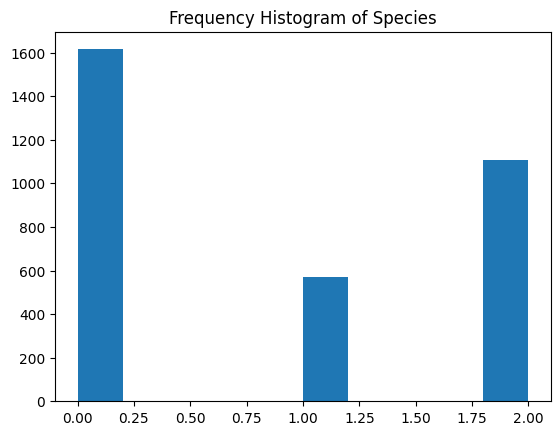

<Figure size 1200x1200 with 0 Axes>

In [15]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

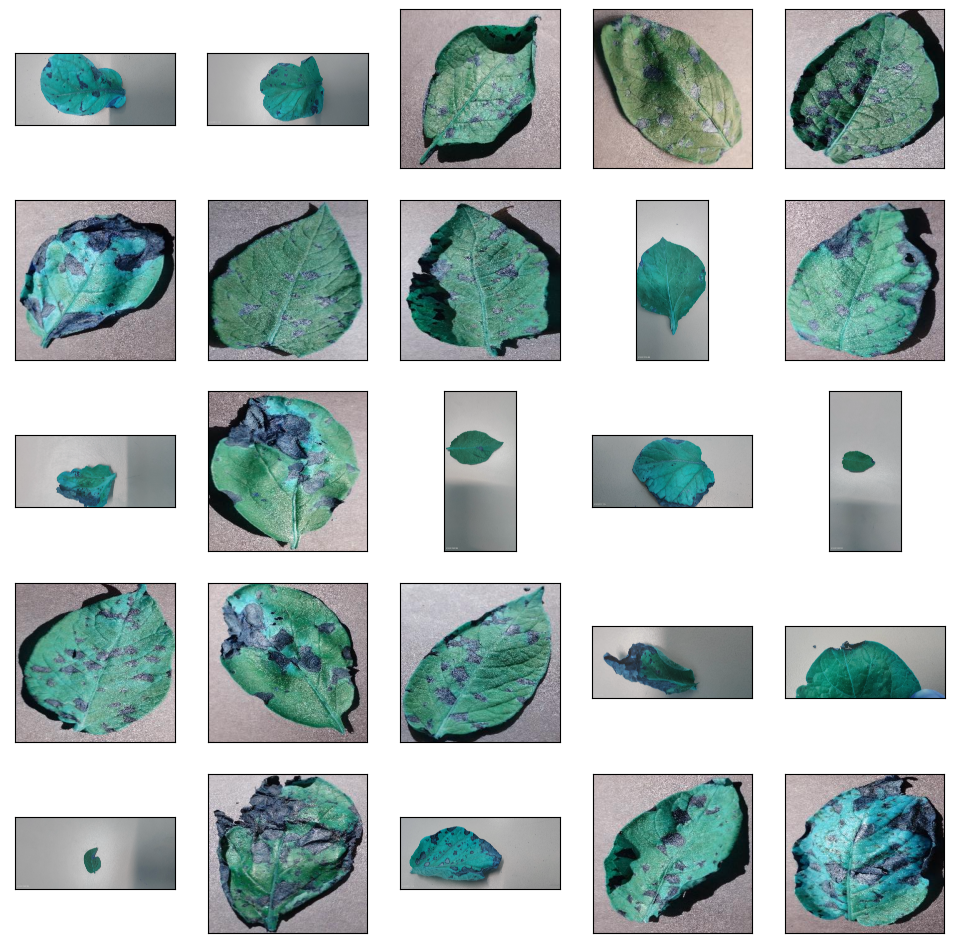

In [16]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_path, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Early_blight', 5, 5)

In [17]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [18]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

3293it [03:45, 14.59it/s]


Train Shape: (3293, 224, 224, 3)


In [19]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [20]:
BATCH_SIZE = 32
#train:val:test = 8:1:1
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [21]:
len(X_train)

2634

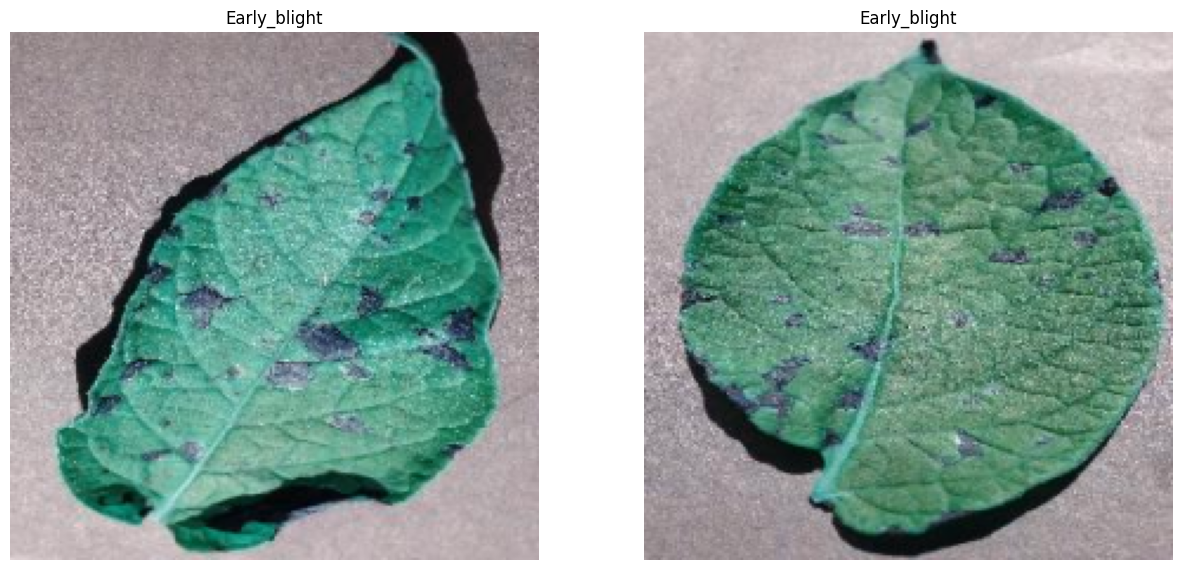

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_type[np.argmax(Y_train[i])])

In [23]:
EPOCHS = 60
SIZE=224
N_ch=3

In [24]:
from collections import Counter
print(Counter(train['Disease Type']))

Counter({'Early_blight': 1615, 'Late_blight': 1106, 'healthy': 572})


In [26]:
class_weights = {0:1615/3293, 1:572/3293, 2:1106/3293}

In [96]:
def build_vgg16():
    densenet = VGG16(weights=None, include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [154]:
# class F1History(tf.keras.callbacks.Callback):

#     def __init__(self, train, validation=None):
#         super(F1History, self).__init__()
#         self.validation = validation
#         self.train = train

#     def on_epoch_end(self, epoch, logs={}):

#         logs['F1_score_train'] = float('-inf')
#         X_train, y_train = self.train[0], self.train[1]
#         y_pred = (self.model.predict(X_train).ravel()>0.5)+0
#         score = f1_score(y_train, y_pred)       

#         if (self.validation):
#             logs['F1_score_val'] = float('-inf')
#             X_valid, y_valid = self.validation[0], self.validation[1]
#             y_val_pred = (self.model.predict(X_valid).ravel()>0.5)+0
#             val_score = f1_score(y_valid, y_val_pred)
#             logs['F1_score_train'] = np.round(score, 5)
#             logs['F1_score_val'] = np.round(val_score, 5)
#         else:
#             logs['F1_score_train'] = np.round(score, 5)

In [155]:
model = build_vgg16()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('potato_vgg16.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=128),
               steps_per_epoch=X_train.shape[0] // 128,
               epochs=60,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val),
               class_weight=class_weights)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 3)       84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_11  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_22 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 512)               0  

C:\Users\User1\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/60

Epoch 1: val_loss improved from inf to 1.09372, saving model to potato_vgg16.h5
20/20 - 33s - loss: 0.3547 - accuracy: 0.5902 - val_loss: 1.0937 - val_accuracy: 0.4992 - lr: 0.0020 - 33s/epoch - 2s/step
Epoch 2/60

Epoch 2: val_loss improved from 1.09372 to 1.08626, saving model to potato_vgg16.h5
20/20 - 29s - loss: 0.3010 - accuracy: 0.6588 - val_loss: 1.0863 - val_accuracy: 0.4992 - lr: 0.0020 - 29s/epoch - 1s/step
Epoch 3/60

Epoch 3: val_loss improved from 1.08626 to 1.08023, saving model to potato_vgg16.h5
20/20 - 30s - loss: 0.2540 - accuracy: 0.7171 - val_loss: 1.0802 - val_accuracy: 0.4992 - lr: 0.0020 - 30s/epoch - 1s/step
Epoch 4/60

Epoch 4: val_loss improved from 1.08023 to 1.07426, saving model to potato_vgg16.h5
20/20 - 29s - loss: 0.2449 - accuracy: 0.7247 - val_loss: 1.0743 - val_accuracy: 0.4992 - lr: 0.0020 - 29s/epoch - 1s/step
Epoch 5/60

Epoch 5: val_loss improved from 1.07426 to 1.06406, saving model to potato_vgg16.h5
20/20 - 30s - loss: 0.2050 - acc


Epoch 41: val_loss did not improve from 0.61130
20/20 - 29s - loss: 0.1124 - accuracy: 0.8348 - val_loss: 2.7401 - val_accuracy: 0.5311 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 42/60

Epoch 42: val_loss did not improve from 0.61130
20/20 - 29s - loss: 0.1258 - accuracy: 0.8404 - val_loss: 2.0498 - val_accuracy: 0.3900 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 43/60

Epoch 43: val_loss did not improve from 0.61130
20/20 - 29s - loss: 0.1163 - accuracy: 0.8436 - val_loss: 0.8569 - val_accuracy: 0.6525 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 44/60

Epoch 44: val_loss did not improve from 0.61130
20/20 - 29s - loss: 0.1253 - accuracy: 0.8388 - val_loss: 1.8503 - val_accuracy: 0.5630 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 45/60

Epoch 45: val_loss did not improve from 0.61130
20/20 - 30s - loss: 0.1115 - accuracy: 0.8480 - val_loss: 1.1071 - val_accuracy: 0.5979 - lr: 0.0010 - 30s/epoch - 1s/step
Epoch 46/60

Epoch 46: val_loss did not improve from 0.61130
20/20 - 29s - loss: 0.1145 - ac

In [156]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

21/21 [==============================] - 2s 87ms/step - loss: 9.5141 - accuracy: 0.4992
Final Loss: 9.514148712158203, Final Accuracy: 0.49924126267433167


21/21 [==============================] - 2s 82ms/step


Text(0.5, 192.58159722222217, 'Predicted')

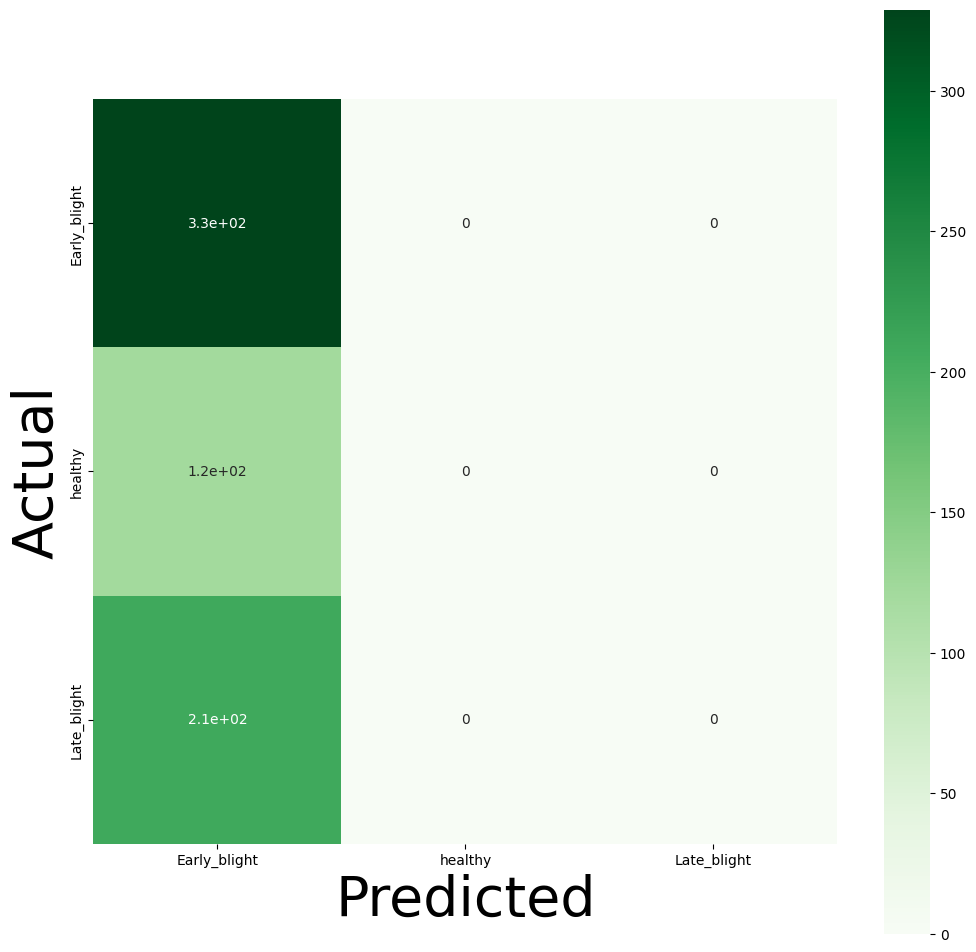

In [157]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_type, yticklabels=disease_type)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [158]:
from sklearn.metrics import classification_report

In [159]:
print(classification_report(Y_true, Y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       329
           1       0.00      0.00      0.00       122
           2       0.00      0.00      0.00       208

    accuracy                           0.50       659
   macro avg       0.17      0.33      0.22       659
weighted avg       0.25      0.50      0.33       659



In [160]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [161]:
print(f1_score(Y_true, Y_pred, average='weighted'))

0.33249064648313903


In [162]:
print(precision_score(Y_true, Y_pred, average='weighted'))

0.2492418503227173


C:\Users\User1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
print(recall_score(Y_true, Y_pred, average='weighted'))

0.4992412746585736


In [164]:
# # accuracy plot 
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [165]:
# # loss plot
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()